Robust MPC: Simulation with linearized rocket system

In [2]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Linearization around a steady state:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]

=== Setting up Tube MPC for Z-dimension ===
Sampling time Ts = 0.0500 s
Horizon N = 100 steps (5.00 s)

Closed-loop eigenvalues: [0.91107967+0.03019032j 0.91107967-0.03019032j]
Max eigenvalue magnitude: 0.9116
LQR gain K = [[-20.04443399 -20.38354266]]

Input disturbance: w_input ∈ [-15.0, 5.0]
State disturbance (B*w): vz ∈ [-0.1298, 0.0433]
                         z  ∈ [-0.0032, 0.0011]
Minimal robust invariant set E converged after 69 iterations.

Minimal invariant set E bounding box:
  vz ∈ [-0.2459, 0.8007]
  z  ∈ [-0.7376, 0.8905]

State constraint (absolute): z >= 0.50 m
State constraint (deviation): z_dev >= -2.50 m
Input constraint: 40.00 <= u <= 80.00

Computing tightened constraints...
  State constraint 0: support_E = 0.7376, tightened by 0.7376
  Input constraint 0: support_KE = -6.2756, tig

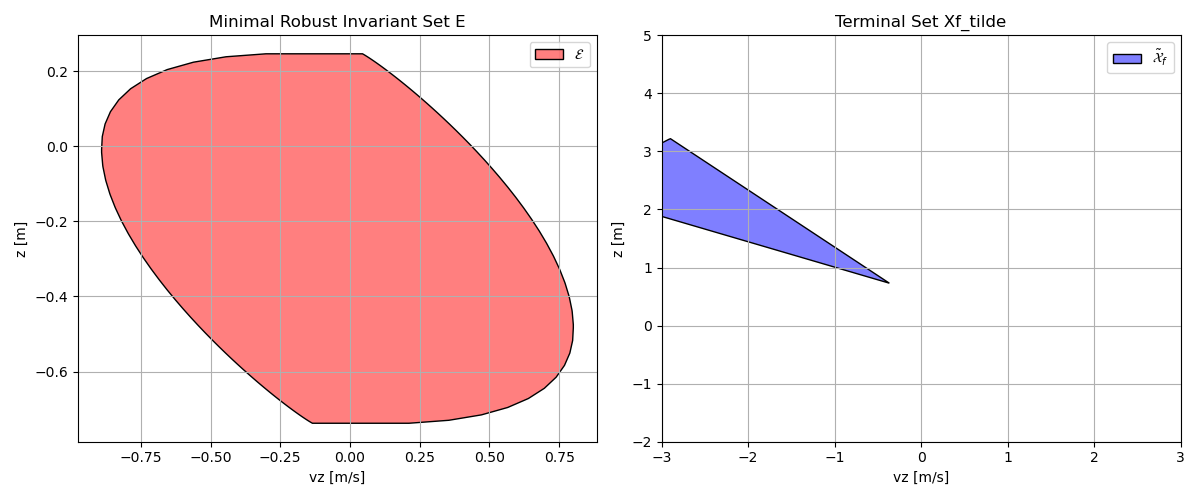


=== Constraint Information ===
Minimal invariant set E:
  Dimension: 2
  H-rep shape: A=(251, 2), b=(251,)

Terminal set Xf_tilde:
  Dimension: 2
  H-rep shape: A=(11, 2), b=(11,)
  Is empty: False
  Is bounded: True

Tightened input constraint U_tilde:
  H-rep: A=[[ 1]
 [-1]], b=[29.60898037  7.52879222]
  Vertices (deviation): [-7.52879222 29.60898037]
  Vertices (absolute): [49.13787445 86.27564704]


In [11]:
from LandMPC.MPCControl_z import MPCControl_z
from src.rocket import Rocket
from src.pos_rocket_vis import *

# Require ipympl
%matplotlib widget 

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7 # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

sim_time = 20  # simulation length in seconds
x0 = np.array([0, #wx [rad/s] y-MPC
               0, #wy [rad/s] x-MPC
               0, #wz [rad/s] roll-MPC
               np.deg2rad(0), #alpha [rad] y-MPC
               np.deg2rad(0), #beta [rad] x-MPC
               np.deg2rad(30), #gamma [rad] roll-MPC
               0, #vx [m/s] x-MPC
               0, #vy [m/s] y-MPC
               0, #vz [m/s] z-MPC
               3, #x [m]
               2, #y [m]
               10  #z [m]
               ])  # initial state   
x_ref = np.array([0, #wx [rad/s] y-MPC
               0, #wy [rad/s] x-MPC
               0, #wz [rad/s] roll-MPC
               np.deg2rad(0), #alpha [rad] y-MPC
               np.deg2rad(0), #beta [rad] x-MPC
               np.deg2rad(0), #gamma [rad] roll-MPC
               0, #vx [m/s] x-MPC
               0, #vy [m/s] y-MPC
               0, #vz [m/s] z-MPC
               1, #x [m]
               0, #y [m]
               3  #z [m]
               ])
xs, us = rocket.trim(x_ref)
print("Linearization around a steady state:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)
sys = rocket.linearize_sys(xs, us)
A, B = sys.A, sys.B


H = 5
mpc = MPCControl_z(A, B, xs, us, Ts, H)

In [ ]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='random')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

In [ ]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='extreme')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

In [ ]:
# Deliverable_6_1.ipynb - Testing Tube MPC for Z-dimension

# Cell 1: Setup
%load_ext autoreload
%autoreload 2

import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src.rocket import Rocket
from LandMPC_template.MPCControl_z import MPCControl_z

rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Cell 2: Initialize system
Ts = 1/20
H = 1  # Horizon time in seconds

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7  # Lower mass for landing phase

# Trim and linearize around target
x_ref = np.array([0.]*9 + [1., 0., 3.])
xs, us = rocket.trim(x_ref)
A, B = rocket.linearize(xs, us)

print("Steady state (xs):", xs)
print("Steady state input (us):", us)
print("\nNote the lower steady-state thrust compared to earlier phases")

# Cell 3: Design Tube MPC for Z
mpc_z_rob = MPCControl_z(A, B, xs, us, Ts, H)

# Cell 4: Test with no noise
print("\n=== Testing with NO NOISE ===")
x0 = np.array([0, 0, 0, 0, 0, np.deg2rad(30), 0, 0, 0, 3, 2, 10])
sim_time = 5.0
t_cl_no, x_cl_no, u_cl_no = rocket.simulate_subsystem(mpc_z_rob, sim_time, x0, 'no_noise')

# Plot
from src.pos_rocket_vis import plot_static_states_inputs
plot_static_states_inputs(t_cl_no[:-1], x_cl_no[:, :-1], u_cl_no, xs, 'sys_z')

# Cell 5: Test with random noise
print("\n=== Testing with RANDOM NOISE ===")
t_cl_rand, x_cl_rand, u_cl_rand = rocket.simulate_subsystem(mpc_z_rob, sim_time, x0, 'random')

# Plot
plot_static_states_inputs(t_cl_rand[:-1], x_cl_rand[:, :-1], u_cl_rand, xs, 'sys_z')

# Cell 6: Test with extreme disturbance
print("\n=== Testing with EXTREME DISTURBANCE ===")
t_cl_ext, x_cl_ext, u_cl_ext = rocket.simulate_subsystem(mpc_z_rob, sim_time, x0, 'extreme')

# Plot
plot_static_states_inputs(t_cl_ext[:-1], x_cl_ext[:, :-1], u_cl_ext, xs, 'sys_z')

# Cell 7: Performance analysis
print("\n=== PERFORMANCE SUMMARY ===")
print(f"Initial z: {x0[11]:.2f} m, Target z: {xs[11]:.2f} m")
print(f"Settling time (no noise): {t_cl_no[np.argmax(np.abs(x_cl_no[11, :] - xs[11]) < 0.1)]:.2f} s")
print(f"Settling time (random): {t_cl_rand[np.argmax(np.abs(x_cl_rand[11, :] - xs[11]) < 0.1)]:.2f} s")
print(f"Settling time (extreme): {t_cl_ext[np.argmax(np.abs(x_cl_ext[11, :] - xs[11]) < 0.1)]:.2f} s")
print(f"\nConstraint z >= 0 satisfied: {np.all(x_cl_ext[11, :] >= -1e-6)}")
print(f"Min z achieved: {np.min(x_cl_ext[11, :]):.3f} m")